In [81]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/home-credit-default-risk/sample_submission.csv
/kaggle/input/home-credit-default-risk/bureau_balance.csv
/kaggle/input/home-credit-default-risk/POS_CASH_balance.csv
/kaggle/input/home-credit-default-risk/application_train.csv
/kaggle/input/home-credit-default-risk/HomeCredit_columns_description.csv
/kaggle/input/home-credit-default-risk/application_test.csv
/kaggle/input/home-credit-default-risk/previous_application.csv
/kaggle/input/home-credit-default-risk/credit_card_balance.csv
/kaggle/input/home-credit-default-risk/installments_payments.csv
/kaggle/input/home-credit-default-risk/bureau.csv


In order to better this score, we will have to include more information from the other dataframes. Here, we will look at using information from the bureau and bureau_balance data. The definitions of these data files are:
다른 데이터프레임들을 활용하여 정보를 좀 더 모으고자 합니다. 여기서는 bureau 및 bureau_balance 데이터를 살펴봅니다. 각 데이터파일의 정의는 다음과 같습니다.

- bureau: information about client's previous loans with other financial institutions reported to Home Credit. Each previous loan has its own row.
- bureau_balance: monthly information about the previous loans. Each month has its own row.

- bureau: 'Home Credit'에 제출된 고객(Client)의 다른 금융기관에서의 과거의 대출 기록. (각각의 대출 기록은 각각의 열로 정리되어있습니다.)
- bureau_balance: 과거 대출들의 월별 데이터.(각 월별 데이터는 각각의 열로 정리되어있습니다.)

Manual feature engineering can be a tedious process (which is why we use automated feature engineering with featuretools!) and often relies on domain expertise. Since I have limited domain knowledge of loans and what makes a person likely to default, I will instead concentrate of getting as much info as possible into the final training dataframe. The idea is that the model will then pick up on which features are important rather than us having to decide that. Basically, our approach is to make as many features as possible and then give them all to the model to use! Later, we can perform feature reduction using the feature importances from the model or other techniques such as PCA.

수작업(Manual) Feature Engineering은 어떻게 보면 지루한 과정일 수 있습니다. (이것은 많은 사람들이 자동화된 Feature Engineering 기능을 활용하는 주된 이유입니다.) 또한, 이 작업은 도메인 지식(domain expertise)을 필요로 하기도 합니다. 대출 및 채무 불이행의 주된 원인에 대한 지식을 갖추는데는 한계가 있기 때문에, 최종 학습용 데이터프레임에서 가능한 많은 정보들을 얻는데 주안점을 두었습니다. *즉, 이 커널은 어떤 Feature들이 중요한지를 결정하는 것에 있어서, 사람보다 모델이 고르도록하는 접근방식을 취합니다.* 기본적으로 이러한 접근방식에서는 최대한 많은 Feature들을 만들고, 모델은 이러한 Feature들을 전부 활용합니다. 그리고 *추후, 모델에서 얻어진 Feature Importance나 PCA를 통해 Feautre Reduction을 할 수 있습니다.*

The process of manual feature engineering will involve plenty of Pandas code, a little patience, and a lot of great practice manipulation data. Even though automated feature engineering tools are starting to be made available, feature engineering will still have to be done using plenty of data wrangling for a little while longer.

수작업(Manual) feature engineering의 각 과정은 많은 양의 Pandas 코드와 약간의 인내심, 특히 데이터 처리에 있어서 많은 인내심을 필요로 합니다. 비록 자동화된 Feature Engineering 도구들이 활용되기 시작했지만, 당분간 Feature Engineering은 여전히 전처리 작업을 필요로 합니다.

In [82]:
# 데이터 처리을 위한 Pandas 및 Numpy
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np


# 시각화를 위한 matplotlib 및 seaborn
# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns


# pandas에서 나오는 경고문 무시
# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

Example: Counts of a client's previous loans
예시 : 고객의 이전 대출 수량 파악 

To illustrate the general process of manual feature engineering, we will first simply get the count of a client's previous loans at other financial institutions. This requires a number of Pandas operations we will make heavy use of throughout the notebook:
Manual feature engineering의 보편적인 방법을 설명하기 위해, 먼저 고객의 과거 타 금융기관에서의 대출 수량을 간단히 파악하고자 합니다. 이 과정은 이 커널에서 반복적으로 사용되는 아래의 Pandas 명령어들을 포함합니다.

groupby: group a dataframe by a column. In this case we will group by the unique client, the SK_ID_CURR column
groupby : Column값에 따라 데이터프레임을 그룹화. 이 과정에서는 SK_ID_CURR Column의 값에 따라 고객별로 데이터프레임을 그룹화 (Link)

agg: perform a calculation on the grouped data such as taking the mean of columns. We can either call the function directly (grouped_df.mean()) or use the agg function together with a list of transforms (grouped_df.agg([mean, max, min, sum]))
agg : 그룹화된 데이터의 평균 등을 계산. 'grouped_df.mean()' 을 통해 직접 평균을 계산하거나, agg 명령어와 리스트를 활용하여 평균, 최대값, 최소값, 합계 등을 계산 ( grouped_df.agg([mean, max, min, sum]) ) (Link)

merge: match the aggregated statistics to the appropriate client. We need to merge the original training data with the calculated stats on the SK_ID_CURR column which will insert NaN in any cell for which the client does not have the corresponding statistic
merge : 집계된(aggregated) 값을 해당 고객와 매칭. SK_ID_CURR Column을 활용하여 집계된 값을 원본 트레이닝 데이터로 병합하고, 해당값이 없을 경우에는 NaN 값을 입력.(Link)

We also use the (rename) function quite a bit specifying the columns to be renamed as a dictionary. This is useful in order to keep track of the new variables we create.

This might seem like a lot, which is why we'll eventually write a function to do this process for us. Let's take a look at implementing this by hand first.

In [83]:
# Read in bureau
bureau = pd.read_csv('/kaggle/input/home-credit-default-risk/bureau.csv')
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [84]:
#개수 세기
# Groupby the client id (SK_ID_CURR), count the number of previous loans, and rename the column
previous_loan_counts = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU': 'previous_loan_counts'})
previous_loan_counts.head()

,SK_ID_CURR,previous_loan_counts
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3


In [85]:
# 훈련용 데이터프레임과 병합(Join)
# Join to the training dataframe
train = pd.read_csv('/kaggle/input/home-credit-default-risk/application_train.csv')
train = train.merge(previous_loan_counts, on = 'SK_ID_CURR', how = 'left')

# NaN 값에 0을 대입
# Fill the missing values with 0 
train['previous_loan_counts'] = train['previous_loan_counts'].fillna(0)
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,previous_loan_counts
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,8.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Assessing Usefulness of New Variable with r value
To determine if the new variable is useful, we can calculate the Pearson Correlation Coefficient (r-value) between this variable and the target. This measures the strength of a linear relationship between two variables and ranges from -1 (perfectly negatively linear) to +1 (perfectly positively linear). The r-value is not best measure of the "usefulness" of a new variable, but it can give a first approximation of whether a variable will be helpful to a machine learning model. The larger the r-value of a variable with respect to the target, the more a change in this variable is likely to affect the value of the target. Therefore, we look for the variables with the greatest absolute value r-value relative to the target.

We can also visually inspect a relationship with the target using the Kernel Density Estimate (KDE) plot.

Kernel Density Estimate Plots
The kernel density estimate plot shows the distribution of a single variable (think of it as a smoothed histogram). To see the different in distributions dependent on the value of a categorical variable, we can color the distributions differently according to the category. For example, we can show the kernel density estimate of the previous_loan_count colored by whether the TARGET = 1 or 0. The resulting KDE will show any significant differences in the distribution of the variable between people who did not repay their loan (TARGET == 1) and the people who did (TARGET == 0). This can serve as an indicator of whether a variable will be 'relevant' to a machine learning model.

We will put this plotting functionality in a function to re-use for any variable.

In [86]:
# Plots the disribution of a variable colored by value of the target
def kde_target(var_name, df):
    
    # Calculate the correlation coefficient between the new variable and the target
    corr = df['TARGET'].corr(df[var_name])
    
    # Calculate medians for repaid vs not repaid
    avg_repaid = df.loc[df['TARGET'] == 0, var_name].median()
    avg_not_repaid = df.loc[df['TARGET'] == 1, var_name].median()
    
    plt.figure(figsize = (12, 6))
    
    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(df.loc[df['TARGET'] == 0, var_name], label = 'TARGET == 0')
    sns.kdeplot(df.loc[df['TARGET'] == 1, var_name], label = 'TARGET == 1')
    
    # label the plot
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend();
    
    # print out the correlation
    print('The correlation between %s and the TARGET is %0.4f' % (var_name, corr))
    # Print out average values
    print('Median value for loan that was not repaid = %0.4f' % avg_not_repaid)
    print('Median value for loan that was repaid =     %0.4f' % avg_repaid)

The correlation between EXT_SOURCE_3 and the TARGET is -0.1789
Median value for loan that was not repaid = 0.3791
Median value for loan that was repaid =     0.5460


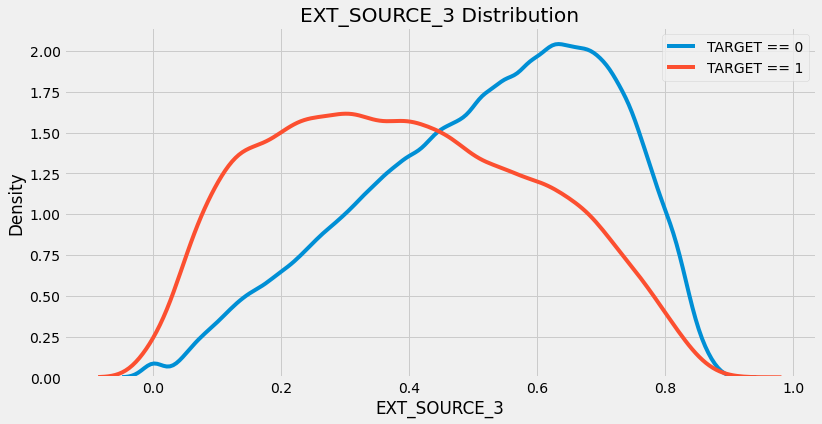

In [87]:
kde_target('EXT_SOURCE_3', train)

이제는 방금 새롭게 만들었던, previous_loan_counts를 살펴보도록 하겠습니다.

The correlation between previous_loan_counts and the TARGET is -0.0100
Median value for loan that was not repaid = 3.0000
Median value for loan that was repaid =     4.0000


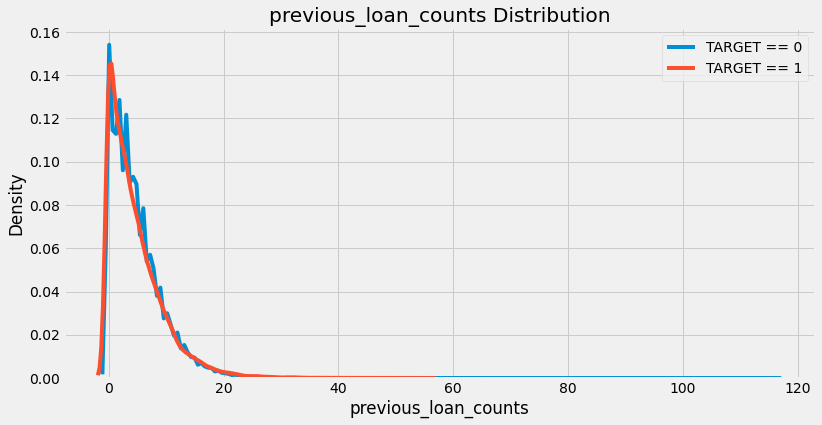

In [88]:
kde_target('previous_loan_counts', train)

이를 통해, 새롭게 생성된 변수(previous_loan_counts Distribution)가 중요하지 않음을 알 수 있습니다. 상관계수가 너무 작으며, target값에 따른 분포의 차이도 거의 없습니다.

이제 bureau 데이터프레임으로부터 몇개의 변수들을 새롭게 생성해보도록 하겠습니다. bureau 데이터프레임의 모든 수치 데이터 Column(numeric column)들로부터 평균, 최소, 최대값을 가져올 예정입니다.

### 수치 데이터의 대표값들을 계산 (Aggregating Numeric Columns)
(*agg를 활용하여 데이터프레임의 평균, 최대값, 최소값, 합계 등을 구하는 것을 대표값들을 계산한다고 번역하였습니다.)

bureau 데이터 프레임 안의 수치 데이터를 활용하기 위해, 모든 수치 데이터 Column의 대표값들을 계산할 것입니다. 이를 위해 고객 ID별로 그룹화(groupby)를 수행하고, 그룹화된 데이터프레임의 대표값들을 agg를 통해 구한 뒤, 결과를 훈련 데이터셋과 병합합니다. agg 함수는 오직 수치 데이터행들의 유효한 대표값들을 계산하는 역할을 수행합니다. 계속해서 mean, max, min, sum 함수를 기본으로 사용할 것이지만, 상황에 따라 어떠한 함수들은 생략될 수 있습니다. 또한, 별도의 함수를 작성한 후 이를 agg 함수를 통해 불러올 수 있습니다.

In [89]:
# 고객 id에 따라 데이터프레임을 그룹화하고, 대표값들을 계산
# Group by the client id, calculate aggregation statistics
bureau_agg = bureau.drop(columns = ['SK_ID_BUREAU']).groupby('SK_ID_CURR', as_index = False).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()
bureau_agg.head()

SK_ID_CURR DAYS_CREDIT                               CREDIT_DAY_OVERDUE  \
                   count         mean  max   min   sum              count   
0     100001           7  -735.000000  -49 -1572 -5145                  7   
1     100002           8  -874.000000 -103 -1437 -6992                  8   
2     100003           4 -1400.750000 -606 -2586 -5603                  4   
3     100004           2  -867.000000 -408 -1326 -1734                  2   
4     100005           3  -190.666667  -62  -373  -572                  3   

                ... DAYS_CREDIT_UPDATE                               \
  mean max min  ...              count        mean  max   min   sum   
0  0.0   0   0  ...                  7  -93.142857   -6  -155  -652   
1  0.0   0   0  ...                  8 -499.875000   -7 -1185 -3999   
2  0.0   0   0  ...                  4 -816.000000  -43 -2131 -3264   
3  0.0   0   0  ...                  2 -532.000000 -382  -682 -1064   
4  0.0   0   0  ...                  3  -54.333333  -11  -121  -163   

  AMT_ANNUITY                                      
        count         mean      max  min      sum  
0           7  3545.357143  10822.5  0.0  24817.5  
1           7     0.000000      0.0  0.0      0.0  
2           0          NaN      NaN  NaN      0.0  
3           0          NaN      NaN  NaN      0.0  
4           3  1420.500000   4261.5  0.0   4261.5  

[5 rows x 61 columns]

생성된 Column들에 대해 새롭게 이름을 적어주는 것이 좋을 것 같습니다. 밑의 코드들은 원본데이터의 Column에 대표값들의 종류들을 추가적으로 기입해주는 역할을 수행합니다. 여기서는 Multi-Level index 데이터프레임을 작업의 대상으로 합니다. 이러한 부분은 혼동을 줄 수 있고, 작업하기도 어렵기 때문에, single-level index로 최대한 빠르게 변환하고자 하였습니다.

In [90]:
# Column 리스트를 생성 
# List of column names
columns = ['SK_ID_CURR']

# 변수(원본 데이터프레임의 column name)에 따라 반복문을 실행
# Iterate through the variables names
for var in bureau_agg.columns.levels[0]:
    # Skip the id name
    if var != 'SK_ID_CURR':
        
        # Iterate through the stat names
        for stat in bureau_agg.columns.levels[1][:-1]:
            # Make a new column name for the variable and stat
            columns.append('bureau_%s_%s' % (var, stat))

In [91]:

# 생성된 list를 데이터프레임의 column name으로 지정
# Assign the list of columns names as the dataframe column names
bureau_agg.columns = columns
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


이제, 이전에 했던대로 간단히 훈련데이터와 결과를 병합합니다.

In [92]:
# 훈련데이터와 병합
# Merge with the training data
train = train.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,8.0,-499.875,-7.0,-1185.0,-3999.0,7.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,4.0,-816.000,-43.0,-2131.0,-3264.0,0.0,NaN,NaN,NaN,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,2.0,-532.000,-382.0,-682.0,-1064.0,0.0,NaN,NaN,NaN,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,1.0,-783.000,-783.0,-783.0,-783.0,0.0,NaN,NaN,NaN,0.0


### 목표값과 대표값들의 상관계수 분석 (Correlations of Aggregated Values with Target)¶

새롭게 생성된 값들과 목표값(target)과의 상관계수를 분석합니다. 다시 말하자면, 이러한 상관계수들은 모델링에 중요한 변수들을 대략적으로 알려줍니다.

In [93]:
# 새로운 상관계수들에 대한 리스트를 생성
# List of new correlations
new_corrs = []

# column별로 반복문을 실행
for col in columns:
    
    # 목표값(target)과의 상관계수를 계산
    # Calculate correlation with the target
    corr = train['TARGET'].corr(train[col])
    
    # 튜플(tuple)로 리스트에 추가
    # Append the list as a tuple
    new_corrs.append((col, corr))

밑의 코드를 통해 sorted 함수를 통해 상관계수들을 절대값에 따라서 정렬하고자 합니다. 또한, 익명의(anonymous) lambda (알아 놓으면 좋은 파이썬의 중요한 기능) 함수도 활용할 것입니다.

In [94]:
# 상관계수들을 절대값에 따라 정렬
# Sort the correlations by the absolute value

# 큰 값부터 앞에 나오게하기 위해서는 'reverse'를 True로 설정해야 합니다.
# Make sure to reverse to put the largest values at the front of list
new_corrs = sorted(new_corrs, key = lambda x: abs(x[1]), reverse = True)
new_corrs[:15]

[('bureau_DAYS_CREDIT_mean', 0.08972896721998116),
 ('bureau_DAYS_CREDIT_min', 0.0752482510301037),
 ('bureau_DAYS_CREDIT_UPDATE_mean', 0.06892735266968675),
 ('bureau_DAYS_ENDDATE_FACT_min', 0.05588737984392084),
 ('bureau_DAYS_CREDIT_ENDDATE_sum', 0.053734895601020544),
 ('bureau_DAYS_ENDDATE_FACT_mean', 0.053199625857586336),
 ('bureau_DAYS_CREDIT_max', 0.04978205463997308),
 ('bureau_DAYS_ENDDATE_FACT_sum', 0.04885350261111596),
 ('bureau_DAYS_CREDIT_ENDDATE_mean', 0.04698275433483542),
 ('bureau_DAYS_CREDIT_UPDATE_min', 0.04286392247073021),
 ('bureau_DAYS_CREDIT_sum', 0.04199982481484676),
 ('bureau_DAYS_CREDIT_UPDATE_sum', 0.04140363535306015),
 ('bureau_DAYS_CREDIT_ENDDATE_max', 0.03658963469632896),
 ('bureau_DAYS_CREDIT_ENDDATE_min', 0.034281109921615996),
 ('bureau_DAYS_ENDDATE_FACT_count', -0.030492306653325526)]

The correlation between bureau_DAYS_CREDIT_mean and the TARGET is 0.0897
Median value for loan that was not repaid = -835.3333
Median value for loan that was repaid =     -1067.0000


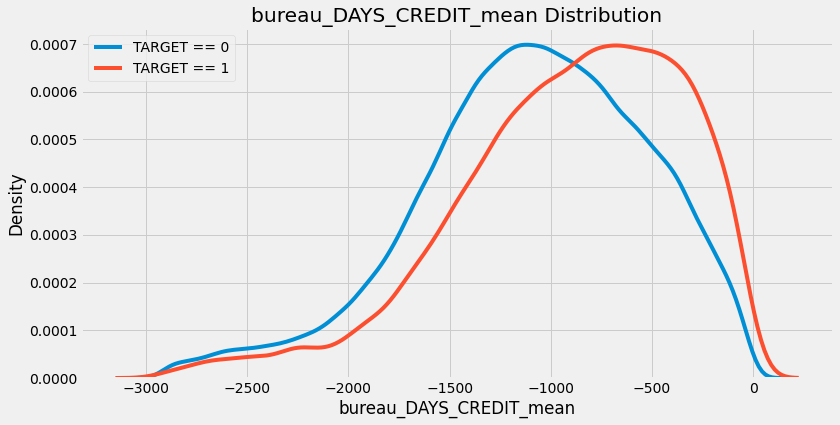

In [95]:
kde_target('bureau_DAYS_CREDIT_mean', train)

이 column은 '고객이 신용관리국 신용등급을 신청한 날로부터 현 대출신청까지 걸린 기간은 몇 일인가? (How many days before current application did client apply for Credit Bureau credit)'에 관한 데이터입니다. 이것을 이전 대출을 받고나서 'Home Credit'에서 대출을 받기전까지 걸린 일수(the number of days)로 해석하려 합니다. 그러므로, 마이너스 수치가 크다는 것은 이전 대출이 이루어진 시점이 더 오래됐음을 의미합니다. 여기서, 이 변수의 평균들과 목표값(target)이 매우 약한 양의 상관관계를 갖는 다는 것은 더 오래된 과거에 대출을 신청했던 고객들은 'Home Credit'에서 대출을 상환할 가능성이 높다는 것을 의미합니다. 그러나 이렇게 약한 상관관계는 그저 노이즈일 가능성도 있습니다.(With a correlation this weak though, it is just as likely to be noise as a signal.)


다중비교문제 (The Multiple Comparisons Problem)

변수가 매우 많을 때는, 다중비교문제로 알려진 우연에 의해 변수들이 목표값(target)에 대해 연관성을 가질 것으로 기대할 수 있습니다. 수백개의 특성(Feature)들을 만들 수 있지만, 몇개의 경우, 그저 데이터안의 랜덤하게 있는 노이즈값들에 의해 목표값(target)과 연관성을 가지는 것처럼 보일 수 있습니다. 이러한 변수들은 훈련 데이터상에서는 목표값과 관련성이 있는 것처럼 보이지만, 관련성들이 테스트 데이터까지 일반화될 수 없기 때문에 모델에 있어 오버피팅(과적합, overfit)을 야기할 수 있습니다. 그렇기에 Feature들을 만드는 것은 많은 고려가 필요합니다.

*(역자의 주) 여기서 다중비교문제란 한 가지 통계적 사실에 대해, 가설을 많이 세울수록 우연에 의해 가설을 충족시킬 결과를 얻을 확률이 높아지는 문제를 말합니다. 마치 원숭이한테 타자를 치라고하고, 유의미한 단어, 문장 등이 나올 때까지 프랑스어, 영어, 스페인어, 독일어 등등일 가설을 세운다면 언젠가는 원하는 결과가 나올 수 있는 것과 비슷한 거 같습니다.

예) 한 가지 약물의 효능을 질병의 여러 증상들 중 하나라도 개선시킬 수 있는 것으로 가정할 경우 : 질병의 증상을 더 많이 고려함에 따라 적어도 하나의 증상에 대해 효능을 가지는 것처럼 보일 가능성이 점점 높아짐. (출처 : Wikipedia, Multiple Comparisons Problem, 접속일 : 2019-05-30)

### 수치데이터의 대표값 연산을 위한 함수 생성 (Function for Numeric Aggregations)

이전의 작업들을 요약하여, 수치데이터의 대표값 계산을 위한 함수를 생성하도록 하겠습니다. 이 함수는 데이터프레임 전체에 걸쳐 수치 데이터 column들의 대표값들을 계산하는 역할을 수행합니다. 추후 다른 데이터프레임에 같은 연산을 적용할 경우, 이 함수를 활용하고자 합니다.

In [96]:
def agg_numeric(df, group_var, df_name):
    """Aggregates the numeric values in a dataframe. This can
    be used to create features for each instance of the grouping variable.
    
    Parameters
    --------
        df (dataframe): 
            the dataframe to calculate the statistics on
        group_var (string): 
            the variable by which to group df
        df_name (string): 
            the variable used to rename the columns
        
    Return
    --------
        agg (dataframe): 
            a dataframe with the statistics aggregated for 
            all numeric columns. Each instance of the grouping variable will have 
            the statistics (mean, min, max, sum; currently supported) calculated. 
            The columns are also renamed to keep track of features created.
    
    """
    # Remove id variables other than grouping variable
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()

    # Need to create new column names
    columns = [group_var]

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        # Skip the grouping variable
        if var != group_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1][:-1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))

    agg.columns = columns
    return agg

In [97]:
bureau_agg_new = agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_agg_new.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


함수가 제대로 작동하는 지 살펴보기 위해, 수작업으로 만든 데이터프레임과 비교해보도록 하겠습니다.

In [98]:
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


값들을 비교해보면, 두 데이터프레임이 동등하게 생성되었다는 것을 알 수 있습니다. 추후, 이 함수를 데이터프레임의 대표값들을 계산하는데 재사용할 수 있을 것입니다. 함수를 사용하면 일관된 결과를 얻을 수 있을 뿐아니라, 해야 할 일의 양을 줄일수 있다는 이점이 있습니다.

상관계수 함수 생성   
: 계속해서 진행하기 전, 목표값(target)과 변수간 상관계수를 계산하기 위한 코드도 작성하도록 하겠습니다.

In [99]:
# Function to calculate correlations with the target for a dataframe
def target_corrs(df):

    # List of correlations
    corrs = []

    # Iterate through the columns 
    for col in df.columns:
        print(col)
        # Skip the target column
        if col != 'TARGET':
            # Calculate correlation with the target
            corr = df['TARGET'].corr(df[col])

            # Append the list as a tuple
            corrs.append((col, corr))
            
    # Sort by absolute magnitude of correlations
    corrs = sorted(corrs, key = lambda x: abs(x[1]), reverse = True)
    
    return corrs

### 범주형 데이터 (Categorical Values)

지금부터는 범주형(categorical) column들을 다뤄보도록 하겠습니다. 주로 문자열 데이터들로써, 이러한 데이터들에 대해서는 평균이나 최대치 등 통계를 활용하기가 어렵습니다. 그 대신, *각 범주별로 값들의 갯수를 셀 것*입니다. 

먼저, 데이터프레임의 범주형 column들에 한하여 one-hot 인코딩을 적용하도록 하겠습니다. (dtype==object)

In [100]:
categorical = pd.get_dummies(bureau.select_dtypes('object'))

categorical['SK_ID_CURR'] = bureau['SK_ID_CURR']
categorical.head()

,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,...,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan,SK_ID_CURR
0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
1,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
2,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354


In [101]:
categorical_grouped = categorical.groupby('SK_ID_CURR').agg(['sum', 'mean'])
categorical_grouped.head()

CREDIT_ACTIVE_Active           CREDIT_ACTIVE_Bad debt       \
                            sum      mean                    sum mean   
SK_ID_CURR                                                              
100001                        3  0.428571                      0  0.0   
100002                        2  0.250000                      0  0.0   
100003                        1  0.250000                      0  0.0   
100004                        0  0.000000                      0  0.0   
100005                        2  0.666667                      0  0.0   

           CREDIT_ACTIVE_Closed           CREDIT_ACTIVE_Sold       \
                            sum      mean                sum mean   
SK_ID_CURR                                                          
100001                        4  0.571429                  0  0.0   
100002                        6  0.750000                  0  0.0   
100003                        3  0.750000                  0  0.0   
100004                        2  1.000000                  0  0.0   
100005                        1  0.333333                  0  0.0   

           CREDIT_CURRENCY_currency 1       ... CREDIT_TYPE_Microloan       \
                                  sum mean  ...                   sum mean   
SK_ID_CURR                                  ...                              
100001                              7  1.0  ...                     0  0.0   
100002                              8  1.0  ...                     0  0.0   
100003                              4  1.0  ...                     0  0.0   
100004                              2  1.0  ...                     0  0.0   
100005                              3  1.0  ...                     0  0.0   

           CREDIT_TYPE_Mobile operator loan      CREDIT_TYPE_Mortgage       \
                                        sum mean                  sum mean   
SK_ID_CURR                                                                   
100001                                    0  0.0                    0  0.0   
100002                                    0  0.0                    0  0.0   
100003                                    0  0.0                    0  0.0   
100004                                    0  0.0                    0  0.0   
100005                                    0  0.0                    0  0.0   

           CREDIT_TYPE_Real estate loan      CREDIT_TYPE_Unknown type of loan  \
                                    sum mean                              sum   
SK_ID_CURR                                                                      
100001                                0  0.0                                0   
100002                                0  0.0                                0   
100003                                0  0.0                                0   
100004                                0  0.0                                0   
100005                                0  0.0                                0   

                 
           mean  
SK_ID_CURR       
100001      0.0  
100002      0.0  
100003      0.0  
100004      0.0  
100005      0.0  

[5 rows x 46 columns]

sum는 고객별 해당 범주에 속한 대출의 총 횟수를 말합니다. 그리고 mean은 횟수를 정규화시킨 것입니다. one-hot 인코딩을 통해 이러한 수치들을 계산하는 과정을 매우 편리하게 만들어줍니다.

여기서, 지난번 column 제목들을 재정의할 때 사용하였던 것과 비슷한 함수를 활용하겠습니다. 다시 말하면, multi-level index로 작성되어있는 column들을 다룰 것입니다. 범주형 데이터가 속한 column의 이름을 차용한 First level(level 0)을 따라 반복문을 먼저 실행하고, 그 다음 계산된 통계치들을 따라 반복문을 한번 더 실행할 것입니다. level 0의 이름에 통계치의 종류를 합쳐 column 제목들을 재정의할 것입니다. 예를 들면, CREDIT_ACTIVE_Active가 level 0이고, sum이 level 1인 column은 CREDIT_ACTIVE_Active_count로 정의됩니다.

In [102]:
categorical_grouped.columns.levels[0][:10]

Index(['CREDIT_ACTIVE_Active', 'CREDIT_ACTIVE_Bad debt',
       'CREDIT_ACTIVE_Closed', 'CREDIT_ACTIVE_Sold',
       'CREDIT_CURRENCY_currency 1', 'CREDIT_CURRENCY_currency 2',
       'CREDIT_CURRENCY_currency 3', 'CREDIT_CURRENCY_currency 4',
       'CREDIT_TYPE_Another type of loan', 'CREDIT_TYPE_Car loan'],
      dtype='object')

In [103]:
categorical_grouped.columns.levels[1]

Index(['sum', 'mean'], dtype='object')

In [104]:
group_var = 'SK_ID_CURR'

# Need to create new column names
columns = []

# Iterate through the variables names
for var in categorical_grouped.columns.levels[0]:
    # Skip the grouping variable
    if var != group_var:
        # Iterate through the stat names
        for stat in ['count', 'count_norm']:
            # Make a new column name for the variable and stat
            columns.append('%s_%s' % (var, stat))

#  Rename the columns
categorical_grouped.columns = columns

categorical_grouped.head()

,CREDIT_ACTIVE_Active_count,CREDIT_ACTIVE_Active_count_norm,CREDIT_ACTIVE_Bad debt_count,CREDIT_ACTIVE_Bad debt_count_norm,CREDIT_ACTIVE_Closed_count,CREDIT_ACTIVE_Closed_count_norm,CREDIT_ACTIVE_Sold_count,CREDIT_ACTIVE_Sold_count_norm,CREDIT_CURRENCY_currency 1_count,CREDIT_CURRENCY_currency 1_count_norm,...,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


sum column은 총 횟수를 나타내며, count_norm column은 횟수를 정규화시킨 것입니다. 이제 이 데이터프레임을 훈련 데이터셋과 합치겠습니다.

In [105]:
train = train.merge(categorical_grouped, left_on = 'SK_ID_CURR', right_index = True, how = 'left')
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [106]:
train.shape

(307511, 229)

In [107]:
train.iloc[:10, 123:]

,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,bureau_CREDIT_DAY_OVERDUE_sum,...,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
0,8.0,-874.000000,-103.0,-1437.0,-6992.0,8.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,-1400.750000,-606.0,-2586.0,-5603.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,-867.000000,-408.0,-1326.0,-1734.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,-1149.000000,-1149.0,-1149.0,-1149.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,3.0,-757.333333,-78.0,-1097.0,-2272.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,18.0,-1271.500000,-239.0,-2882.0,-22887.0,18.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2.0,-1939.500000,-1138.0,-2741.0,-3879.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,4.0,-1773.000000,-1309.0,-2508.0,-7092.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 범주형 데이터들을 처리하기 위한 함수 생성 (Function to Handle Categorical Variables)¶

코드를 좀 더 효율적으로 만들기 위해, 범주형 데이터들을 처리하기 위한 함수를 만들 것입니다. agg_numeric 함수를 만들 때 했던 것과 같은 방식으로 데이터 프레임을 그룹화할 것입니다. 그 다음 각각의 범주에 따라 counts와 normalized counts를 계산할 것입니다.

In [108]:
def count_categorical(df, group_var, df_name):
    """Computes counts and normalized counts for each observation
    of `group_var` of each unique category in every categorical variable
    
    Parameters
    --------
    df : dataframe 
        The dataframe to calculate the value counts for.
        
    group_var : string
        The variable by which to group the dataframe. For each unique
        value of this variable, the final dataframe will have one row
        
    df_name : string
        Variable added to the front of column names to keep track of columns

    
    Return
    --------
    categorical : dataframe
        A dataframe with counts and normalized counts of each unique category in every categorical variable
        with one row for every unique value of the `group_var`.
        
    """
    
    # Select the categorical columns
    categorical = pd.get_dummies(df.select_dtypes('object'))

    # Make sure to put the identifying id on the column
    categorical[group_var] = df[group_var]

    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(group_var).agg(['sum', 'mean'])
    
    column_names = []
    
    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['count', 'count_norm']:
            # Make a new column name
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    return categorical

In [109]:
bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_counts.head()

,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Bad debt_count,bureau_CREDIT_ACTIVE_Bad debt_count_norm,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_count_norm,bureau_CREDIT_CURRENCY_currency 1_count,bureau_CREDIT_CURRENCY_currency 1_count_norm,...,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


### 다른 데이터프레임에 대해 적용 (Applying Operations to another dataframe)
이제 'bureau balance' 데이터프레임을 활용해보도록 하겠습니다. 이 데이터프레임은 월별 각 고객의 과거 타 금융기관 대출 데이터를 포함하고 있습니다. 고객들의 ID인 SK_ID_CURR에 따라 그룹화하기보다, 이전 대출의 ID인 SK_ID_BUREAU를 활용하여 1차 그룹화를 진행할 것입니다. 그룹화한 데이터프레임은 각각의 대출에 대한 정보를 행별로 포함할 것입니다. 그 다음, SK_ID_CURR을 활용하여 그룹화한 뒤, 각 고객별 대출의 대표값(aggreation)들을 계산할 것입니다. 최종 산출물은 각각의 행에 고객별로 대출에 대한 대표값들을 포함하고 있을 것입니다.

In [110]:
# Read in bureau balance
bureau_balance = pd.read_csv('/kaggle/input/home-credit-default-risk/bureau_balance.csv')
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


먼저, 각각의 대출별 상태(status)의 갯수를 세도록 하겠습니다. 운 좋게도, 이미 함수를 만들어놓은 상태입니다

In [111]:
# Counts of each type of status for each previous loan
bureau_balance_counts = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_counts.head()

,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
SK_ID_BUREAU,,,,,,,,,,,,,,,,
5001709,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
5001710,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446
5001711,3,0.750000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000
5001712,10,0.526316,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000
5001713,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000


이제, 수치형(numeric) column을 다루도록 하겠습니다. MONTHS_BALACE column은 신청일을 기준으로 한 남은 개월 수를 나타냅니다. 별로 중요하지 않은 변수일 수도 있겠지만, 추후 time variable로 활용할 수 있을 수도 있습니다. 지금은 이전에 했던 것과 같이 대표값들을 계산하도록 하겠습니다.

In [112]:
# Calculate value count statistics for each `SK_ID_CURR` 
bureau_balance_agg = agg_numeric(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_agg.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum
0,5001709,97,-48.0,0,-96,-4656
1,5001710,83,-41.0,0,-82,-3403
2,5001711,4,-1.5,0,-3,-6
3,5001712,19,-9.0,0,-18,-171
4,5001713,22,-10.5,0,-21,-231


위의 데이터프레임들은 각각의 대출에 대해 계산한 것입니다. 이제 이것을 가각의 고객별로 계산할 필요가 있습니다. 이를 위해 먼저 데이터 프레임을 합치고, 그 다음 모든 수치형(numeric) 데이터에 한하여 대표값들을 다시 계산하도록 하겠습니다. 이번에는 SK_ID_CURR을 기준으로 그룹화를 하도록 하겠습니다.

In [113]:
# Dataframe grouped by the loan
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')

# Merge to include the SK_ID_CURR
bureau_by_loan = bureau_by_loan.merge(bureau[['SK_ID_BUREAU', 'SK_ID_CURR']], on = 'SK_ID_BUREAU', how = 'left')

bureau_by_loan.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,...,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm,SK_ID_CURR
0,5001709,97,-48.0,0,-96,-4656,0,0.000000,0,0.0,...,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402,NaN
1,5001710,83,-41.0,0,-82,-3403,5,0.060241,0,0.0,...,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446,162368.0
2,5001711,4,-1.5,0,-3,-6,3,0.750000,0,0.0,...,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000,162368.0
3,5001712,19,-9.0,0,-18,-171,10,0.526316,0,0.0,...,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000,162368.0
4,5001713,22,-10.5,0,-21,-231,0,0.000000,0,0.0,...,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000,150635.0


In [114]:
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'client')
bureau_balance_by_client.head()

,SK_ID_CURR,client_bureau_balance_MONTHS_BALANCE_count_count,client_bureau_balance_MONTHS_BALANCE_count_mean,client_bureau_balance_MONTHS_BALANCE_count_max,client_bureau_balance_MONTHS_BALANCE_count_min,client_bureau_balance_MONTHS_BALANCE_count_sum,client_bureau_balance_MONTHS_BALANCE_mean_count,client_bureau_balance_MONTHS_BALANCE_mean_mean,client_bureau_balance_MONTHS_BALANCE_mean_max,client_bureau_balance_MONTHS_BALANCE_mean_min,...,client_bureau_balance_STATUS_X_count_count,client_bureau_balance_STATUS_X_count_mean,client_bureau_balance_STATUS_X_count_max,client_bureau_balance_STATUS_X_count_min,client_bureau_balance_STATUS_X_count_sum,client_bureau_balance_STATUS_X_count_norm_count,client_bureau_balance_STATUS_X_count_norm_mean,client_bureau_balance_STATUS_X_count_norm_max,client_bureau_balance_STATUS_X_count_norm_min,client_bureau_balance_STATUS_X_count_norm_sum
0,100001.0,7,24.571429,52,2,172,7,-11.785714,-0.5,-25.5,...,7,4.285714,9,0,30.0,7,0.214590,0.500000,0.0,1.502129
1,100002.0,8,13.750000,22,4,110,8,-21.875000,-1.5,-39.5,...,8,1.875000,3,0,15.0,8,0.161932,0.500000,0.0,1.295455
2,100005.0,3,7.000000,13,3,21,3,-3.000000,-1.0,-6.0,...,3,0.666667,1,0,2.0,3,0.136752,0.333333,0.0,0.410256
3,100010.0,2,36.000000,36,36,72,2,-46.000000,-19.5,-72.5,...,2,0.000000,0,0,0.0,2,0.000000,0.000000,0.0,0.000000
4,100013.0,4,57.500000,69,40,230,4,-28.250000,-19.5,-34.0,...,4,10.250000,40,0,41.0,4,0.254545,1.000000,0.0,1.018182


종합하겠습니다. 이 단계에서는 bureau_balance데이터프레임에 대해 다음과 같은 과정을 밟아나갔습니다.

각각의 대출에 대해 수치형(numeric) 대표값들을 계산 (Calculated numeric stats grouping by each loan)
각각의 대출에 대해 범주형(categorical) 데이터들의 갯수를 파악 (Made value counts of each categorical variable grouping by loan)
각각의 대출에 대한 대표값들과 갯수를 병합 (Merged the stats and the value counts on the loans)
각 고객별로 3의 결과에 대한 수치형 대표값들을 계산 (Calculated numeric stats for the resulting dataframe grouping by the client id)
최종 데이터프레임은 각 고객에 대한 개별 행으로 구성되며, 각 행은 이전 모든 대출들의 월별 정보들의 통계치들로 구성되어 있습니다.

몇몇 변수들은 약간 헷갈립니다. 예를 들어 설명하자면

client_bureau_balance_MONTHS_BALANCE_mean_mean : 각각의 대출에 대한 MONTHS_BALANCE의 평균값을 계산, 그 다음 클라이언트별 대출의 평균값을 계산
client_bureau_balance_STATUS_X_count_norm_sum : 각각의 대출에 대해 STATUS == x 인것의 빈도를 총 STATUS 수로 나눈 다음, 개별 클라이언트별로 그 수를 합산
최종 데이터프레임에 모든 결과를 합치기 전까지는 상관계수(correlation)를 계산하지 않겠습니다.

### 생성된 함수의 병합 (Putting the Functions Together)   
   
이제, 타 기관에서의 과거 대출 이력과 대출에 관한 월별 정보들을 구하고, 이것들을 훈련용 데이터프레임과 병합시킬 준비가 다되었습니다. 모든 변수들을 초기화한 뒤, 생성된 함수들을 사용하여 처음부터 만들어나가겠습니다. 이러한 과정은 반복해야하는 작업 공정에서 함수를 활용했을 때의 이점을 보여줍니다.

In [115]:
# Free up memory by deleting old objects
import gc
gc.enable()
del train, bureau, bureau_balance, bureau_agg, bureau_agg_new, bureau_balance_agg, bureau_balance_counts, bureau_by_loan, bureau_balance_by_client, bureau_counts
gc.collect()

22

In [116]:
# Read in new copies of all the dataframes
train = pd.read_csv('/kaggle/input/home-credit-default-risk/application_train.csv')
bureau = pd.read_csv('/kaggle/input/home-credit-default-risk/bureau.csv')
bureau_balance = pd.read_csv('/kaggle/input/home-credit-default-risk/bureau_balance.csv')

Bureau 데이터프레임 내 범주형 데이터의 갯수 세기 (Counts of Bureau Dataframe)

In [117]:
bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_counts.head()

,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Bad debt_count,bureau_CREDIT_ACTIVE_Bad debt_count_norm,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_count_norm,bureau_CREDIT_CURRENCY_currency 1_count,bureau_CREDIT_CURRENCY_currency 1_count_norm,...,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


Bureau 데이터프레임의 대표값 계산 (Aggregated Stats of Bureau Dataframe)

In [118]:
bureau_agg = agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


Bureau Balance 데이터프레임의 각 대출별 범주형 데이터 갯수 세기 (Value counts of Bureau Balance dataframe by loan)

In [119]:
bureau_balance_counts = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_counts.head()

,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
SK_ID_BUREAU,,,,,,,,,,,,,,,,
5001709,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
5001710,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446
5001711,3,0.750000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000
5001712,10,0.526316,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000
5001713,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000


Bureau Balance 데이터프레임의 각 대출별 대표값 계산 (Aggregated stats of Bureau Balance dataframe by loan)

In [120]:
bureau_balance_agg = agg_numeric(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_agg.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum
0,5001709,97,-48.0,0,-96,-4656
1,5001710,83,-41.0,0,-82,-3403
2,5001711,4,-1.5,0,-3,-6
3,5001712,19,-9.0,0,-18,-171
4,5001713,22,-10.5,0,-21,-231


Bureau Balance 데이터프레임의 고객별 대표값 계산 (Aggregated Stats of Bureau Balance by Client)

In [121]:
# Dataframe grouped by the loan
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')

# Merge to include the SK_ID_CURR
bureau_by_loan = bureau[['SK_ID_BUREAU', 'SK_ID_CURR']].merge(bureau_by_loan, on = 'SK_ID_BUREAU', how = 'left')

# Aggregate the stats for each client
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'client')

계산된 특성(Feature)들을 훈련용 데이터와 병합 (Insert Computed Features into Training Data)

In [122]:
original_features = list(train.columns)
print('Original Number of Features: ', len(original_features))

Original Number of Features:  122


In [123]:
# Merge with the value counts of bureau
train = train.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')

# Merge with the stats of bureau
train = train.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')

# Merge with the monthly information grouped by client
train = train.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

In [124]:
new_features = list(train.columns)
print('Number of features using previous loans from other institutions data: ', len(new_features))

Number of features using previous loans from other institutions data:  333


Feature Engineering 결과물 (Feature Engineering Outcomes)  

이제 모든 작업들을 마치고, 생성된 변수들(variables)을 살펴보고자 합니다. 누락된 값(missing values)의 비율, 목표값(target)과의 상관계수, 변수간 상관계수들을 살펴볼 것입니다. 각 변수간의 높은 상관관계는 변수 간 collinear 관계를 가지는 지 여부를 보여줄 수 있으며, 이는 변수들이 서로 강한 연관관계를 가짐을 의미합니다. 종종 collinear한 두 변수를 모두 갖는 것은 중복이기 때문에 하나를 제거해야할 필요가 있기도 합니다. 또한 누락된 값들의 백분율을 활용하여 대부분의 값이 존재하지 않는 feature들을 제거할 수도 있습니다. Feature Selection은 앞으로의 과정에 있어 중요한 초점이 될 것입니다. Feature의 수를 줄이는 것은 모델 학습과 더불어 일반화를 도울 수 있습니다. 'Curse of dimensionality (차원의 저주)'는 너무 많은 feature를 가질 때 생기는 문제를 말합니다.(Feature 갯수가 많은 것 = 지나치게 고차원) 변수의 수가 증가함에 따라 변수와 목표값 사이의 상관관계를 학습하는데 필요한 데이터(datapoints)의 수는 기하급수적으로 증가합니다.

Feature seletion은 모델 학습 및 일반화를 위해 변수들을 제거하는 과정입니다. 필요없고, 중복인 변수들을 제거하고, 중요한 변수들을 보존하는 것이 목적입니다. 이 과정에서 쓸 수 있는 툴들은 여러가지가 있지만, 이 커널에서는 누락된 값들이 많거나, 다른 변수들에 대해 높은 상관관계들을 갖는 변수를 제거하는 방법을 사용할 것입니다. 그 다음, Gradient Boosting Machine과 Random Forest 모델로부터 반환된 Feature importance를 활용하는 방법도 알아볼 것입니다.

누락된 값 (Missing Values)  
  
데이터프레임 내의 누락된 값들은 중요한 고려사항입니다. 누락된 값이 많은 column은 삭제해야 할 수도 있습니다.

In [125]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [126]:
missing_train = missing_values_table(train)
missing_train.head(10)

Your selected dataframe has 333 columns.
There are 278 columns that have missing values.


,Missing Values,% of Total Values
bureau_AMT_ANNUITY_min,227502,74.0
bureau_AMT_ANNUITY_max,227502,74.0
bureau_AMT_ANNUITY_mean,227502,74.0
client_bureau_balance_STATUS_4_count_min,215280,70.0
client_bureau_balance_STATUS_3_count_norm_mean,215280,70.0
client_bureau_balance_MONTHS_BALANCE_count_min,215280,70.0
client_bureau_balance_STATUS_4_count_max,215280,70.0
client_bureau_balance_STATUS_4_count_mean,215280,70.0
client_bureau_balance_STATUS_3_count_norm_min,215280,70.0
client_bureau_balance_STATUS_3_count_norm_max,215280,70.0


누락된 값의 비율이 높은 column이 여러 개 있음을 알 수 있습니다. 누락된 값을 제거하는데 있어 기준이 되는 정해진 비율은 없으며, 문제에 따라 달라집니다. 여기서는 훈련데이터 및 테스트 데이터에 있어 90%의 이상의 누락값을 가진 column들을 제거하겠습니다.

In [127]:
missing_train_vars = list(missing_train.index[missing_train['% of Total Values'] > 90])
len(missing_train_vars)

0

누락된 값들을 제거하기 앞서, 테스트 데이터에서의 누락된 값의 비율을 살펴보겠습니다. 그 다음 훈련 또는 테스트 데이터에 있어 90% 이상 누락된 값을 가진 column들을 제거하겠습니다. 이제, 테스트데이터를 불러온 뒤 같은 연산들을 적용하고, 테스트 데이터안의 누락된 값들을 살펴보겠습니다. 이미, 갯수 및 대표값들을 계산한 뒤이므로, 테스트 데이터를 계산된 데이터들과 병합하기만 하면 됩니다.

In [128]:
# Read in the test dataframe
test = pd.read_csv('/kaggle/input/home-credit-default-risk/application_test.csv')

# Merge with the value counts of bureau
test = test.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')

# Merge with the stats of bureau
test = test.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')

# Merge with the value counts of bureau balance
test = test.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

In [129]:
print('Shape of Testing Data: ', test.shape)

Shape of Testing Data:  (48744, 332)


이제 훈련용 데이터와 테스트 데이터프레임이 같은 column들을 가지도록 맞춰보겠습니다. 여기서는 문제가 되지 않지만, 변수들을 one-hot 인코딩할 때에는 데이터프레임들이 동일한 column을 가지도록 맞춰야 합니다.

In [130]:
train_labels = train['TARGET']

# Align the dataframes, this will remove the 'TARGET' column
train, test = train.align(test, join = 'inner', axis = 1)

train['TARGET'] = train_labels

In [131]:
print('Training Data Shape: ', train.shape)
print('Testing Data Shape: ', test.shape)

Training Data Shape:  (307511, 333)
Testing Data Shape:  (48744, 332)


In [132]:
missing_test = missing_values_table(test)
missing_test.head(10)

Your selected dataframe has 332 columns.
There are 275 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,33495,68.7
COMMONAREA_MODE,33495,68.7
COMMONAREA_AVG,33495,68.7
NONLIVINGAPARTMENTS_MEDI,33347,68.4
NONLIVINGAPARTMENTS_AVG,33347,68.4
NONLIVINGAPARTMENTS_MODE,33347,68.4
FONDKAPREMONT_MODE,32797,67.3
LIVINGAPARTMENTS_MEDI,32780,67.2
LIVINGAPARTMENTS_MODE,32780,67.2
LIVINGAPARTMENTS_AVG,32780,67.2


In [133]:
missing_test_vars = list(missing_test.index[missing_test['% of Total Values'] > 90])
len(missing_test_vars)

0

In [134]:
missing_columns = list(set(missing_test_vars + missing_train_vars))
print('There are %d columns with more than 90%% missing in either the training or testing data.' % len(missing_columns))

There are 0 columns with more than 90% missing in either the training or testing data.


In [135]:
# Drop the missing columns
train = train.drop(columns = missing_columns)
test = test.drop(columns = missing_columns)

90% 이상 누락된 값을 가진 column들이 없기 때문에, 이번에는 어떠한 column들도 제거되지 않았습니다. Feature selection을 위해서는 아마도 다른 방법을 적용해야 할 것 같습니다.

이 시점에서 훈련용 데이터와 테스트용 데이터들을 저장하도록 하겠습니다. 누락된 값들을 제거하기 위해, 다른 비율을 설정하고, 결과물을 비교해보는 것도 좋은 방법입니다.

In [136]:
train.to_csv('train_bureau_raw.csv', index = False)
test.to_csv('test_bureau_raw.csv', index = False)

### 상관계수 (Correlations)  
  
목표값(target)과 변수(variable)들간 상관계수를 살펴보도록 하겠습니다. 위에서 새롭게 생성된 변수들 중 기존 훈련용 데이터(application 데이터에 있던) 변수들보다 더 높은 상관계수를 가지는 변수를 찾을 수 있습니다.

In [138]:
# Calculate all correlations in dataframe
corrs = train.corr()

In [140]:
corrs = corrs.sort_values('TARGET', ascending = False)

# Ten most positive correlations
pd.DataFrame(corrs['TARGET'].head(10))

,TARGET
TARGET,1.000000
bureau_DAYS_CREDIT_mean,0.089729
client_bureau_balance_MONTHS_BALANCE_min_mean,0.089038
DAYS_BIRTH,0.078239
bureau_CREDIT_ACTIVE_Active_count_norm,0.077356
client_bureau_balance_MONTHS_BALANCE_mean_mean,0.076424
bureau_DAYS_CREDIT_min,0.075248
client_bureau_balance_MONTHS_BALANCE_min_min,0.073225
client_bureau_balance_MONTHS_BALANCE_sum_mean,0.072606
bureau_DAYS_CREDIT_UPDATE_mean,0.068927


In [141]:
# Ten most negative correlations
pd.DataFrame(corrs['TARGET'].dropna().tail(10))

,TARGET
client_bureau_balance_MONTHS_BALANCE_count_min,-0.048224
client_bureau_balance_STATUS_C_count_norm_mean,-0.055936
client_bureau_balance_STATUS_C_count_max,-0.061083
client_bureau_balance_STATUS_C_count_mean,-0.062954
client_bureau_balance_MONTHS_BALANCE_count_max,-0.068792
bureau_CREDIT_ACTIVE_Closed_count_norm,-0.079369
client_bureau_balance_MONTHS_BALANCE_count_mean,-0.080193
EXT_SOURCE_1,-0.155317
EXT_SOURCE_2,-0.160472
EXT_SOURCE_3,-0.178919


목표값과 가장 큰 상관계수를 가지는 변수는 새롭게 생성된 변수입니다. 그러나 상관계수가 높다는 것이 그 변수가 유용하다는 것을 의미하지는 않으며, 수백개의 변수들을 생성했을 경우에는, 그저 random noise 때문에 상관관계에 있는 것처럼 보일 수도 있다는 것을 명심해야 합니다.

비판적으로 상관계수들을 들여다봤을 때, 그래도 새롭게 생성된 몇몇 변수들은 유용할 것처럼 보입니다. 변수들의 유용성(usefulness)를 평가하기 위해, 학습된 모델로부터 Feature Importance를 살펴보도록 하겠습니다. 호기심을 충족시키기위해 (그리고 이미 함수를 작성하였기 때문에) 새롭게 생성된 변수들에 대한 kde 그래프를 작성할 수 있습니다.

The correlation between client_bureau_balance_MONTHS_BALANCE_count_mean and the TARGET is -0.0802
Median value for loan that was not repaid = 19.3333
Median value for loan that was repaid =     25.1429


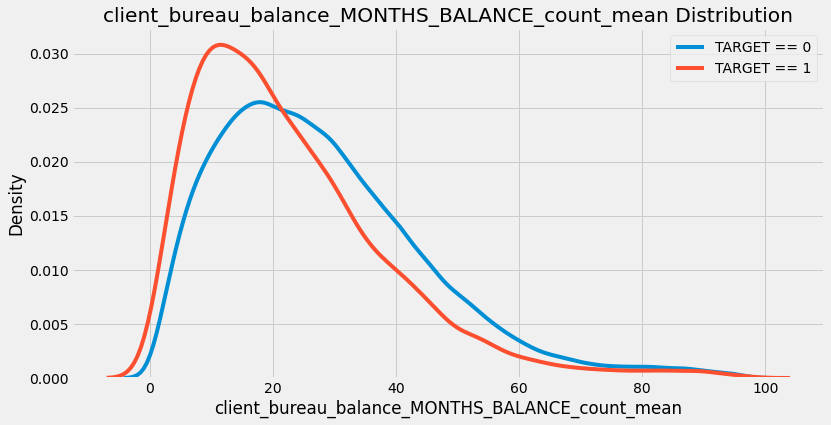

In [142]:
# 원문에는 client_bureau_balance_counts_mean 을 사용하고 있지만 해당 변수가 없어,
# 'client_bureau_balance_MONTHS_BALANCE_count_mean'으로 대체

kde_target(var_name='client_bureau_balance_MONTHS_BALANCE_count_mean', df=train)

(원문에는 client_bureau_balance_counts_mean 을 사용하고 있지만 해당 변수가 없어, client_bureau_balance_MONTHS_BALANCE_count_mean'으로 대체하였습니다.)

이 변수는 각 고객의 대출별 월별 기록에 대한 평균을 의미합니다. 예를들어, 만약 고객의 과거 월별로 3, 4, 5의 기록을 갖고 있는 3개의 대출을 갖고 있다면, 이 변수에 있어 데이터값은 4가 됩니다. 분산 그래프에 기초하여, 과거 월별 평균이 높은 사람들이 Home Credit에서의 대출에서 상환을 잘하는 것으로 보입니다. 이 변수에 대해 너무 많이 분석하지는 않겠습니다. 다만, 이 변수는 더 많은 신용 기록을 가지고 있는 고객들이 일반적으로 대출금을 상환할 가능성이 더 높다는 것을 나타낼 수 있습니다.

The correlation between bureau_CREDIT_ACTIVE_Active_count_norm and the TARGET is 0.0774
Median value for loan that was not repaid = 0.5000
Median value for loan that was repaid =     0.3636


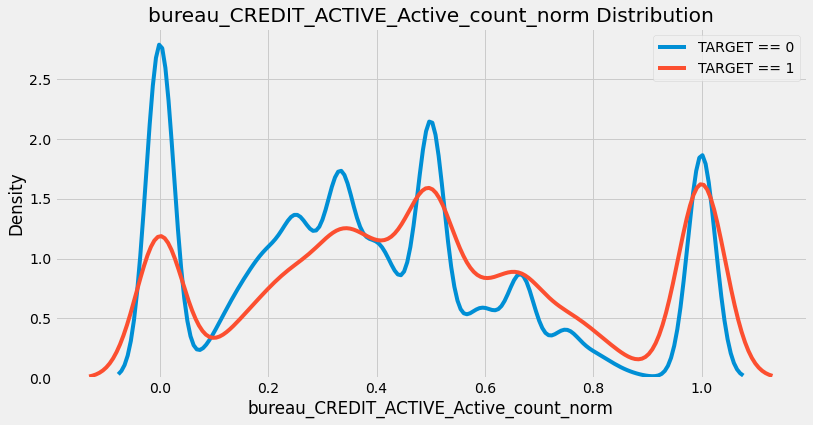

In [143]:
kde_target(var_name='bureau_CREDIT_ACTIVE_Active_count_norm', df=train)

이 변수의 경우 모든 곳에서 불규칙합니다. 이 변수는 CREDIT_ACTIVE의 값이 'Active'인 것의 갯수를 전체 대출 갯수로 나눈 값입니다. 상관관계가 매우 약하기 때무에, 별도의 결론은 생각하지 않도록 하겠습니다.

Collinear Variables
목표값(target)과 변수간의 상관계수만 계산하는 것이 아닌, 각 변수간 상관계수까지 계산할 수 있습니다. 이러한 방법은 제거해야 할 수도 있는 collinear 관계들을 가지는 변수들이 있는지 여부를 알려줍니다.

0.8 이상의 상관계수를 가지는 변수들을 찾아보도록하겠습니다.

참고자료 : 'Collinearity', Britannica.com

In [144]:
# Set the threshold
threshold = 0.8

# Empty dictionary to hold correlated variables
above_threshold_vars = {}

# For each column, record the variables that are above the threshold
for col in corrs:
    above_threshold_vars[col] = list(corrs.index[corrs[col] > threshold])

높은 상관관계를 가지는 변수들의 쌍에 대해서, 하나의 변수만을 제거해야 합니다. 아래의 코드는 각각의 쌍에서 한 개의 변수들만을 저장하는 set을 만드는 역할을 수행합니다.

In [145]:
# Track columns to remove and columns already examined
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

# Iterate through columns and correlated columns
for key, value in above_threshold_vars.items():
    # Keep track of columns already examined
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            # Only want to remove one in a pair
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)
            
cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove))

Number of columns to remove:  134


이제 훈련용 데이터와 테스트 데이터에서 column들을 제거할 수 있습니다. 다만, column들을 제거한 데이터와 그렇지 않은 데이터로부터의 성능을 비교해보아야 합니다.(앞서 저장한 csv 파일을 활용할 수 있습니다.)

In [146]:
train_corrs_removed = train.drop(columns = cols_to_remove)
test_corrs_removed = test.drop(columns = cols_to_remove)

print('Training Corrs Removed Shape: ', train_corrs_removed.shape)
print('Testing Corrs Removed Shape: ', test_corrs_removed.shape)

Training Corrs Removed Shape:  (307511, 199)
Testing Corrs Removed Shape:  (48744, 198)


In [147]:
train_corrs_removed.to_csv('train_bureau_corrs_removed.csv', index = False)
test_corrs_removed.to_csv('test_bureau_corrs_removed.csv', index = False)

모델링 (Modeling)
이제 새롭게 생성된 데이터셋의 성능을 평가하기 위해, 이 데이터셋을 머신러닝에 사용하도록 하겠습니다. 여기서는 다른 노트북(커널)에서 만들었던 함수를 활용해서, 다른 두 데이터셋(기존 데이터셋과, column들을 제거한 데이터셋)의 성능을 비교해보도록 하겠습니다. 이러한 종류의 어떠한 실험도 할 수 있으며, 비교대상(control, 통제집단)은 application 데이터만 이 함수에 사용한 뒤, 제출했을 때의 점수입니다. 이미 그 점수는 기록해놓았으므로, 두 테스트 데이터셋(기존 데이터셋과, column들을 제거한 데이터셋)으로부터의 결과와 비교해볼 수 있습니다.

모든 데이터셋에 대해, 아래와 같은 모델(정확히 같은 파라미터)를 사용할 것입니다.

control : application 데이터만 사용하여 얻은 결과
test one : application 데이터와 더불어 bureau 및 bureau_balance 파일로부터 얻은 데이터를 사용하여 얻은 결과
test two : application 데이터와 더불어 bureau 및 bureau_balance 파일로부터 얻은 데이터를 사용하되 높은 상관관계를 가지는 변수들을 제거하여 얻은 결과

In [148]:
import lightgbm as lgb

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

import gc

import matplotlib.pyplot as plt

In [149]:
def model(features, test_features, encoding = 'ohe', n_folds = 5):
    
    """Train and test a light gradient boosting model using
    cross validation. 
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use 
            for training a model. Must include the TARGET column.
        test_features (pd.DataFrame): 
            dataframe of testing features to use
            for making predictions with the model. 
        encoding (str, default = 'ohe'): 
            method for encoding categorical variables. Either 'ohe' for one-hot encoding or 'le' for integer label encoding
            n_folds (int, default = 5): number of folds to use for cross validation
        
    Return
    --------
        submission (pd.DataFrame): 
            dataframe with `SK_ID_CURR` and `TARGET` probabilities
            predicted by the model.
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
    
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics

In [150]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

Control (비교군)
우선, 비교군(Control)에 함수를 적용해보도록 하겠습니다. 여기서는 위에서 작성한 함수를 application데이터에 적용해보도록 하겠습니다.

In [151]:
train_control = pd.read_csv('/kaggle/input/home-credit-default-risk/application_train.csv')
test_control = pd.read_csv('/kaggle/input/home-credit-default-risk/application_test.csv')

다행히도, 시간을 들여 함수를 작성했기 때문에, 간편히 사용할 수 있습니다. (함수를 활용하여 과정을 간략화하고, 생산적으로 만드는 것은 이 커널에서의 주요 주제입니다.) 함수는 우리가 컴페티션에 제출할 submission 데이터프레임을 반환함과 더불어 feature importance가 저장된 fi 데이터프레임, validation 및 test 점수가 저장된 metrics 데이터프레임을 반환합니다.

In [152]:
submission, fi, metrics = model(train_control, test_control)


Training Data Shape:  (307511, 241)
Testing Data Shape:  (48744, 241)
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.7989	train's binary_logloss: 0.547642	valid's auc: 0.755463	valid's binary_logloss: 0.563361
[400]	train's auc: 0.82864	train's binary_logloss: 0.518235	valid's auc: 0.755594	valid's binary_logloss: 0.544951
Early stopping, best iteration is:
[309]	train's auc: 0.815791	train's binary_logloss: 0.531059	valid's auc: 0.755755	valid's binary_logloss: 0.55289
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.798638	train's binary_logloss: 0.547974	valid's auc: 0.758354	valid's binary_logloss: 0.56326
Early stopping, best iteration is:
[282]	train's auc: 0.811912	train's binary_logloss: 0.53493	valid's auc: 0.758533	valid's binary_logloss: 0.555531
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.7977	train's binary_logloss: 0.549358	valid's auc: 0.763287	valid's binary_logl

In [153]:
metrics

,fold,train,valid
0,0,0.815791,0.755755
1,1,0.811912,0.758533
2,2,0.811252,0.763822
3,3,0.805899,0.758345
4,4,0.807459,0.758535
5,overall,0.810463,0.759002


비교군의 경우, training 점수가 vailidation 점수보다 높으므로, 약간 과적합(overfit)되었다고 볼 수 있습니다. 이 문제는 regualarization을 다루는 다음 커널에서 다뤄보도록 하겠습니다. (이 커널에서는 이미 early stopping 뿐아니라 reg_lambda, reg_alpha와 같은 파라미터들을 설정함으로써, 몇가지 regularization 방법을 사용했습니다.)

이제 plot_feature_importances를 활용하여 feature importance를 시각화해보도록 하겠습니다. 이 feature_importance들은 feature selection에 유용하게 사용할 수 있습니다.

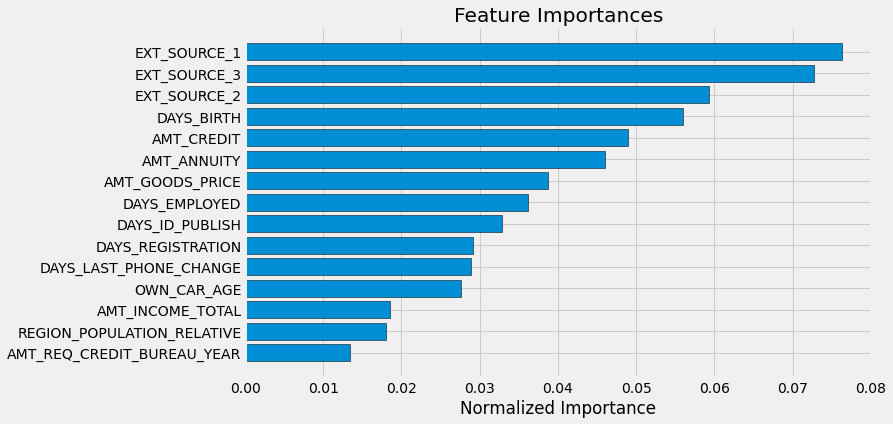

In [154]:
fi_sorted = plot_feature_importances(fi)

In [155]:
submission.to_csv('control.csv', index = False)

제출결과, 비교군(control)의 점수는 0.745를 기록했습니다.


Test One
이제 첫번째 테스트를 해보겠습니다. 함수에 데이터를 입력할 것이고, 이로써 대부분의 작업들이 수행될 것입니다.

In [156]:
submission_raw, fi_raw, metrics_raw = model(train, test)

Training Data Shape:  (307511, 452)
Testing Data Shape:  (48744, 452)
[200]	train's auc: 0.810821	train's binary_logloss: 0.53617	valid's auc: 0.763279	valid's binary_logloss: 0.553134
Early stopping, best iteration is:
[271]	train's auc: 0.82366	train's binary_logloss: 0.523194	valid's auc: 0.76373	valid's binary_logloss: 0.544893
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.810727	train's binary_logloss: 0.53666	valid's auc: 0.765248	valid's binary_logloss: 0.553447
Early stopping, best iteration is:
[276]	train's auc: 0.824682	train's binary_logloss: 0.522383	valid's auc: 0.76609	valid's binary_logloss: 0.544495
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.809569	train's binary_logloss: 0.538079	valid's auc: 0.770517	valid's binary_logloss: 0.55476
Early stopping, best iteration is:
[294]	train's auc: 0.826798	train's binary_logloss: 0.520697	valid's auc: 0.771361	valid's binary_logloss: 0.543955
Training un

In [157]:
metrics_raw

,fold,train,valid
0,0,0.823660,0.763730
1,1,0.824682,0.766090
2,2,0.826798,0.771361
3,3,0.817720,0.766206
4,4,0.821525,0.764642
5,overall,0.822877,0.766403


이러한 수치들에 기반했을 때, 만들어진(engineered) feature들은 비교군보다 더 나은 성능을 보입니다. 그러나 높은 validation 점수가 test로도 이어진다고 단정하기 위해서는 결과를 제출해봐야 합니다

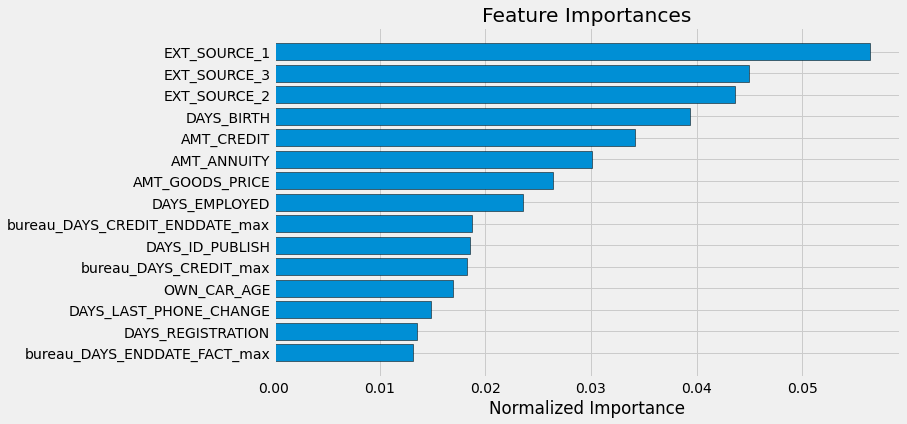

In [158]:
fi_raw_sorted = plot_feature_importances(fi_raw)

feature importance를 살펴보면, 위에서 새롭게 생성된 몇몇 feature들이 중요한 것으로 나타났습니다. 상위 100개의 feature 중 커널에서 새롭게 생성된 것들의 비율을 살펴보도록 하겠습니다. 단순히 기존 feature들과 비교하기 보다는, one hot 인코딩된 feature들과 비교해보야 합니다. 이것은 이미 fi 변수에 저장되어 있습니다.

In [159]:
top_100 = list(fi_raw_sorted['feature'])[:100]
new_features = [x for x in top_100 if x not in list(fi['feature'])]

print('%% of Top 100 Features created from the bureau data = %d.00' % len(new_features))

% of Top 100 Features created from the bureau data = 52.00


과반수의 feature들이 새롭게 생성된 것입니다. 이는 위에서의 고단한 작업들이 의미가 있었음을 의미합니다. :)

In [160]:
submission_raw.to_csv('test_one.csv', index = False)



제출결과, test one의 점수는 0.759를 기록했습니다.

Test two
이제 다른 테스트를 해보도록 하겠습니다. 전과 비슷하지만, 강한 collinear를 가지는 변수들이 제거된 데이터를 사용할 것입니다.

In [161]:
submission_corrs, fi_corrs, metrics_corr = model(train_corrs_removed, test_corrs_removed)

Training Data Shape:  (307511, 318)
Testing Data Shape:  (48744, 318)
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.807062	train's binary_logloss: 0.539926	valid's auc: 0.761756	valid's binary_logloss: 0.555974
Early stopping, best iteration is:
[274]	train's auc: 0.81989	train's binary_logloss: 0.526962	valid's auc: 0.762222	valid's binary_logloss: 0.547766
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.807403	train's binary_logloss: 0.539835	valid's auc: 0.762487	valid's binary_logloss: 0.556178
Early stopping, best iteration is:
[249]	train's auc: 0.816296	train's binary_logloss: 0.53081	valid's auc: 0.762811	valid's binary_logloss: 0.5508
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.806206	train's binary_logloss: 0.541195	valid's auc: 0.766958	valid's binary_logloss: 0.557491
[400]	train's auc: 0.83864	train's binary_logloss: 0.508571	valid's auc: 0.767385	valid's binary_l

In [162]:
metrics_corr

,fold,train,valid
0,0,0.819890,0.762222
1,1,0.816296,0.762811
2,2,0.835801,0.767546
3,3,0.807812,0.763488
4,4,0.823635,0.761030
5,overall,0.820687,0.763372


결과를 살펴보면, 비교군보다는 좋은 성능을 보여주지만, test one보다는 약간 낮은 성능을 보여줍니다.

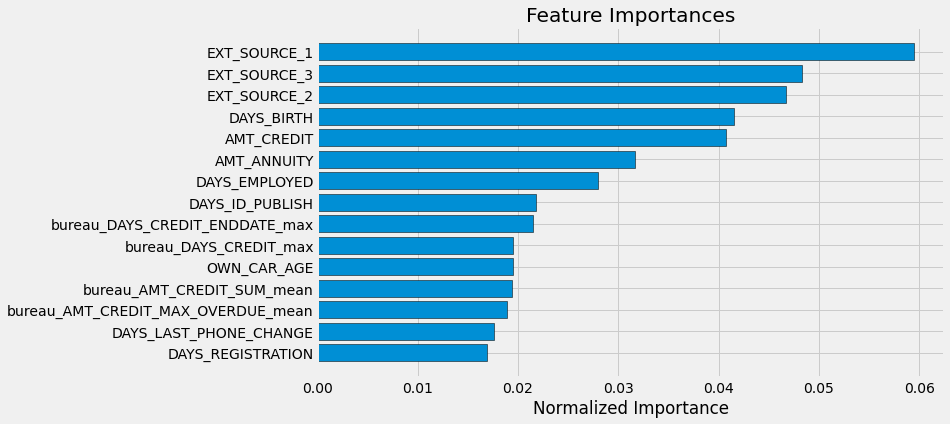

In [163]:
fi_corrs_sorted = plot_feature_importances(fi_corrs)

In [164]:
submission_corrs.to_csv('test_two.csv', index = False)


제출결과, test two의 점수는 0.753을 기록했습니다.

결론 (Results)
결론적으로, 추가된 정보들이 성능을 향상시켰다고 말할 수 있습니다! 모델은 분명히 최적화되지 않았지만, 기존 데이터에 연산된 feature들을 추가하였을 때, 눈에 띄는 성능의 향상이 있었습니다. 결과를 요약해보도록 하겠습니다.

Experiment	Train AUC	Validation AUC	Test AUC
Control	0.815	0.760	0.745
Test One	0.837	0.767	0.759
Test Two	0.826	0.765	0.753
(이러한 점수들은 커널을 실행할때마다 바뀔 수 있음을 유의하십시오)

위에서 했던 모든 노력들은 기존 test 데이터에 비해 0.014의 ROC AUC의 개선으로 이어졌습니다. 강한 collinear 변수들을 제거한 것이 성능 저하로 이어졌기 때문에, feature selection에 있어 다른 방법들을 고려하려합니다. 또한, 모델이 중요하다고 판단한 몇몇 feature들은 새롭게 생성된 feature들이었습니다.

이러한 컴페티션에서는 위와 같은 개선으로서 리더보드에서 100위 정도를 향상시킬 수 있습니다. 이 커널에서와 같은 수많은 작은 개선점들을 활용하여 점차적으로 성능을 개선시킬 수 있습니다. 이러한 결과들을 활용하여, 다른 분들이 각자 성능을 개선시키는 것을 권장하며, 저는 계속해서 다른 사람들을 돕기 위해 과정들을 문서화할 예정입니다.

다음 단계 (Next Steps)
앞으로, 이 커널에서 만들어진 함수들은 다른 데이터셋에서 활용할 수 있습니다. 아직 4개의 다른 데이터셋을 모델에 활용할 수 있습니다. 다음 커널에서는 이러한 다른 데이터(Home Credit의 이전 대출들을 담고 있는)의 정보를 훈련용 데이터셋에 포함시킬 것입니다. 그 다음, 동일한 모델을 만들고 계속해서 실험함으로써 feature engineering의 효과들을 측정할 수 있습니다. 이 컴퍼티션에서는 아직 수행해야할 작업들이 많이 남아있고, 이로써 개선의 여지 역시 많이 남아있습니다. 다음 커널에서 뵙겠습니다.